In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing Libraries
import re
from cleantext import clean
from wordcloud import WordCloud

# NLTK for Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sklearn Libraries for Preprocessing, Model Training, and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, multilabel_confusion_matrix

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# Boosting Algorithms
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')

# For saving the model
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# DATA EXPLORATION

In [2]:
# Loading the dataset
df = pd.read_csv('../Dataset/OriginalDataset.csv')

In [3]:
# Displaying the first few rows of the dataset
print("Dataset Overview:")
print(df.head())

Dataset Overview:
                                                text              label
0  @ZubearSays Any real nigga isn't letting this ...     ethnicity/race
1  @MoradoSkittle @prolifejewess @DAConsult @Kell...  not_cyberbullying
2        the only thing i wish, i wish a nigga would     ethnicity/race
3  You saudias are not friends of Muslim idiots c...           religion
4  @JaydenT2399 @TractorLaw @holmes_gael @erconge...           religion


In [4]:
# Shape of the dataset
print("Shape of the Dataset:", df.shape)

Shape of the Dataset: (99990, 2)


In [5]:
# Basic Information about the Dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    99990 non-null  object
 1   label   99990 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
None


In [6]:
# Summary statistics of the dataset
print("Dataset Description:")
print(df.describe())

Dataset Description:
          text              label
count    99990              99990
unique   99989                  4
top     #NAME?  not_cyberbullying
freq         2              50000


# Exploratory Data Analysis

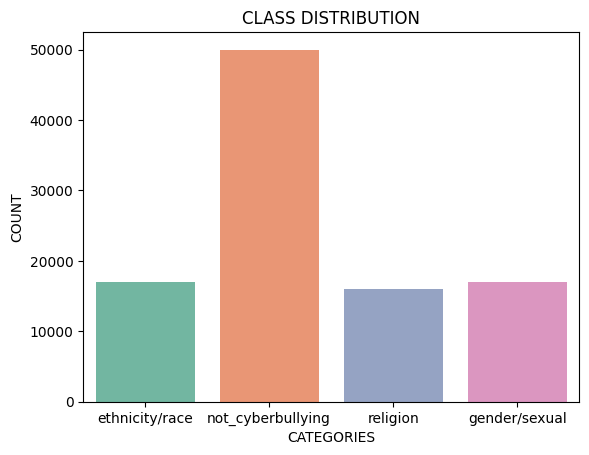

In [7]:
# Class distribution visualization
sns.countplot(x='label', data=df, palette='Set2')
plt.title('CLASS DISTRIBUTION')
plt.xlabel('CATEGORIES')
plt.ylabel('COUNT')
plt.show()

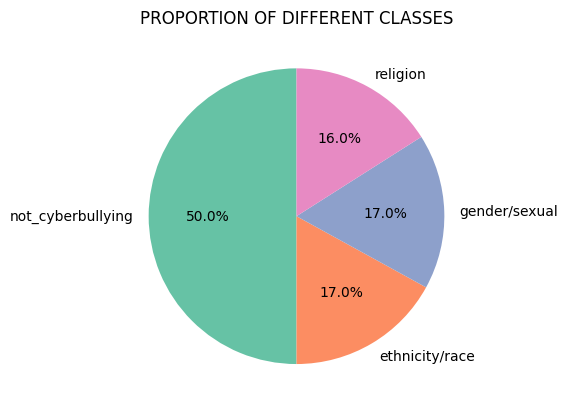

In [8]:
# Pie chart for class distribution
df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2', 5))
plt.title('PROPORTION OF DIFFERENT CLASSES')
plt.ylabel('')
plt.show()

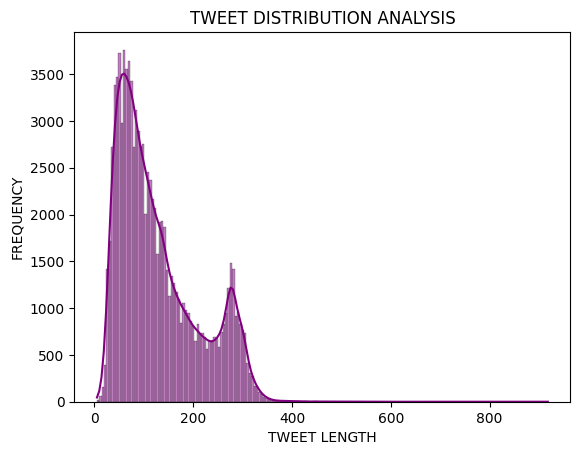

In [9]:
# Length of tweets analysis
df['tweet_length'] = df['text'].apply(len)

sns.histplot(df['tweet_length'], kde=True, color='purple')
plt.title('TWEET DISTRIBUTION ANALYSIS')
plt.xlabel('TWEET LENGTH')
plt.ylabel('FREQUENCY')
plt.show()

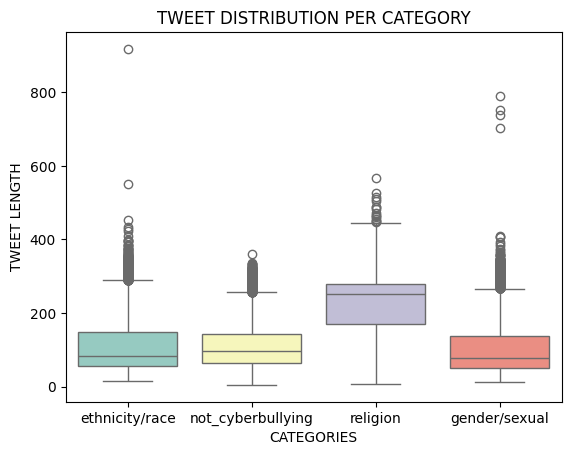

In [10]:
# Tweet length distribution per class
sns.boxplot(x='label', y='tweet_length', data=df, palette='Set3')
plt.title('TWEET DISTRIBUTION PER CATEGORY')
plt.xlabel('CATEGORIES')
plt.ylabel('TWEET LENGTH')
plt.show()

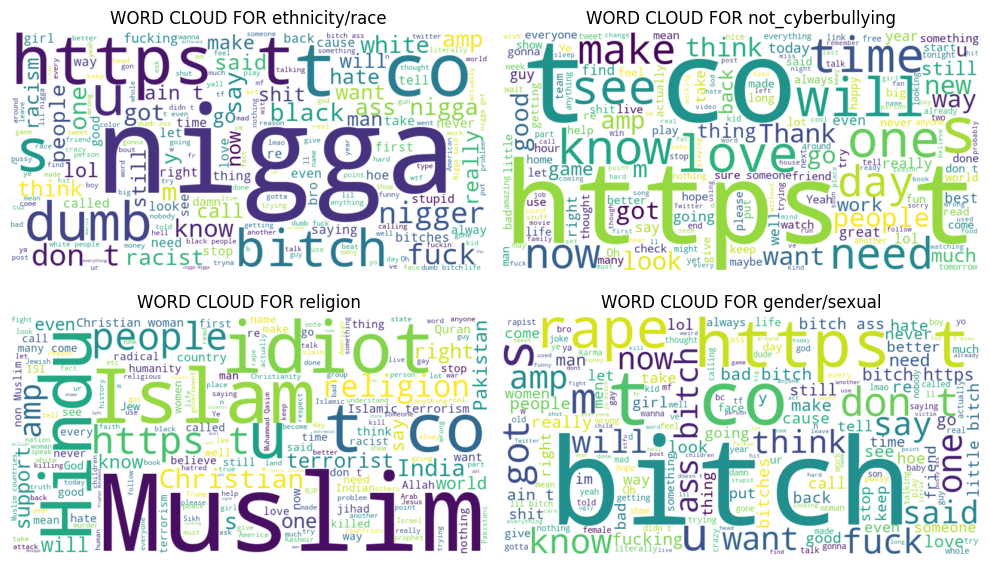

In [11]:
# Word cloud visualization for each class in a 2x2 grid
def generate_wordcloud_2x2(df):
    categories = df['label'].unique()
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    axs = axs.flatten()  # Flattening to easily iterate over axes
    for i, category in enumerate(categories):
        category_data = df[df['label'] == category]['text']
        wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(category_data))
        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].set_title(f'WORD CLOUD FOR {category}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate word cloud for each category in 2x2 layout
generate_wordcloud_2x2(df)

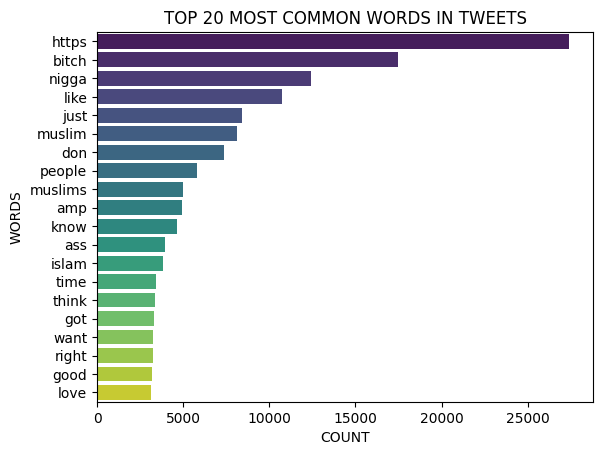

In [12]:
# Most common words in each class using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['text'])

# Barplot of most common words
common_words = vectorizer.get_feature_names_out()
word_counts = X.sum(axis=0).A1
common_word_df = pd.DataFrame({'word': common_words, 'count': word_counts})

sns.barplot(x='count', y='word', data=common_word_df.sort_values(by='count', ascending=False), palette='viridis')
plt.title('TOP 20 MOST COMMON WORDS IN TWEETS')
plt.xlabel('COUNT')
plt.ylabel('WORDS')
plt.show()

# DATA PREPROCESSING

In [13]:
# Function to clean a given sentence by removing or modifying unwanted elements
def clean_sentence(text):
    # Use the clean-text library to perform various cleaning tasks on the text
    cleaned_text = clean(
        text,
        to_ascii=True,               # Convert Unicode characters to their closest ASCII equivalent
        lower=True,                  # Convert all characters in the text to lowercase
        no_line_breaks=True,         # Remove line breaks to make the text a single line
        no_urls=True,                # Remove any URLs from the text
        no_emails=True,              # Remove email addresses
        no_phone_numbers=True,       # Remove phone numbers
        no_numbers=True,             # Remove all numeric values (e.g., "123")
        no_digits=True,              # Remove digit characters (e.g., "1", "2")
        no_currency_symbols=True,    # Remove any currency symbols (e.g., "$", "€")
        no_punct=True,               # Remove punctuation marks (e.g., ".", ",", "!")
        replace_with_punct="",       # Specify what to replace punctuation marks with
        replace_with_url="",         # Specify what to replace URLs with
        replace_with_email="",       # Specify what to replace email addresses with
        replace_with_phone_number="",# Specify what to replace phone numbers with
        replace_with_number="",      # Specify what to replace numbers with
        replace_with_digit="",       # Specify what to replace digit characters with
        replace_with_currency_symbol="", # Specify what to replace currency symbols with
        lang="en"                    # Set the language to English for language-specific cleaning
    )
    return cleaned_text

In [14]:
# Function to remove emojis and certain special symbols from a given string
def remove_emojis(data):
    # Compile a regular expression pattern to match a range of Unicode characters typically used for emojis and special symbols
    emoji_pattern = re.compile(
        "["  # Start of character set

        # Ranges for various emoji categories
        u"\U0001F600-\U0001F64F"  # Emoticons, such as smiley faces and other facial expressions
        u"\U0001F300-\U0001F5FF"  # Miscellaneous symbols, pictographs, weather icons, etc.
        u"\U0001F680-\U0001F6FF"  # Transport-related symbols, including vehicles, map symbols, etc.
        u"\U0001F1E0-\U0001F1FF"  # Regional flags, often represented in pairs for country flags
        u"\U00002500-\U00002BEF"  # Chinese characters, used in various contexts
        u"\U00002702-\U000027B0"  # Miscellaneous symbols, including checkmarks and stars
        u"\U000024C2-\U0001F251"  # Additional enclosed characters and compatibility symbols
        u"\U0001F926-\U0001F937"  # Emojis depicting human gestures and actions
        u"\U00010000-\U0010FFFF"  # Supplemental symbols and pictographs, including rare emoji
        u"\u2640-\u2642"          # Gender symbols
        u"\u2600-\u2B55"          # Various other symbols, including zodiac signs and geometric shapes
        u"\u200D"                 # Zero-width joiner, used for combining emoji sequences
        u"\u23CF"                 # Eject button symbol
        u"\u23E9"                 # Fast forward button
        u"\u231A"                 # Watch symbol
        u"\uFE0F"                 # Variation selector, used to specify emoji styles
        u"\u3030"                 # Wavy dash

        "]+"                      # End of character set, match one or more occurrences
        , re.UNICODE               # Enable Unicode matching
    )

    # Replace all matching emoji patterns in the input text with an empty string
    return re.sub(emoji_pattern, '', data)

In [15]:
# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  # Get English stopwords
    words = text.split()  # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    return ' '.join(filtered_words)   # Join the filtered words back into a string

In [16]:
# Remove mentions like @hello
def remove_mentions(text):
    mention_pattern = r"@\w+"   # Regular expression pattern to match mentions
    return re.sub(mention_pattern, '', text)  # Replace mentions with an empty string

In [17]:
# Function to clean the text column
def clean_text(df, col):
    df[col] = df[col].apply(func=clean_sentence)
    df[col] = df[col].apply(func=remove_emojis)
    df[col] = df[col].apply(func=remove_stopwords)
    df[col] = df[col].apply(func=remove_mentions)
    return df

In [18]:
# Apply the cleaning function to the dataset
df = clean_text(df, 'text')

In [19]:
# Displaying the first few rows of the cleaned dataset
print("Cleaned Dataset Overview:")
print(df.head())

Cleaned Dataset Overview:
                                                text              label  \
0          zubearsays real nigga isnt letting happen     ethnicity/race   
1  moradoskittle prolifejewess daconsult kellyyod...  not_cyberbullying   
2                        thing wish wish nigga would     ethnicity/race   
3     saudias friends muslim idiots cheapless people           religion   
4  jaydent tractorlaw holmesgael erconger acyn ye...           religion   

   tweet_length  
0            53  
1           162  
2            43  
3            61  
4           324  


# DATA PREPARATION


In [20]:
# Encoding labels
label_enc = LabelEncoder()
df['label_encoded'] = label_enc.fit_transform(df['label'].values)

In [21]:
# Create a dictionary for original labels and their corresponding encoded values
label_mapping_dict = dict(zip(label_enc.classes_, range(len(label_enc.classes_))))

# Print the label mapping
print("Label Mapping:", label_mapping_dict)

Label Mapping: {'ethnicity/race': 0, 'gender/sexual': 1, 'not_cyberbullying': 2, 'religion': 3}


In [22]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_encoded'], test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (79992,) (79992,)
Testing set shape: (19998,) (19998,)


In [23]:
# Creating a TF-IDF Vectorizer
tfv = TfidfVectorizer(
    min_df=3,
    strip_accents='unicode',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 3),
    sublinear_tf=True
)

In [24]:
# Fit the TF-IDF vectorizer on the training data
tfv.fit(X_train)

TfidfVectorizer(min_df=3, ngram_range=(1, 3), strip_accents='unicode',
                sublinear_tf=True, token_pattern='\\w{1,}')

In [25]:
# Transform the training and test data
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [26]:
# Display the shapes of the transformed datasets
print("TF-IDF Training set shape:", X_train_tfv.shape)
print("TF-IDF Testing set shape:", X_test_tfv.shape)

TF-IDF Training set shape: (79992, 63555)
TF-IDF Testing set shape: (19998, 63555)


In [27]:
# Saving the TF-IDF Vectorizer to a .pkl file
joblib.dump(tfv, '../Artifacts/TFIDFVectorizer.pkl')

['../Artifacts/TFIDFVectorizer.pkl']

# MODELS

## Random Forest

In [30]:
# Initialize the Random Forest Classifier
model1 = RandomForestClassifier(n_estimators=100, random_state=42)

In [30]:
# Train the model
model1.fit(X_train_tfv, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Make predictions on the test set
y_pred_rf = model1.predict(X_test_tfv)

In [32]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_enc.classes_))

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       1.00      0.99      0.99      3425
    gender/sexual       1.00      0.99      0.99      3336
not_cyberbullying       0.99      1.00      1.00     10082
         religion       1.00      0.99      0.99      3155

         accuracy                           0.99     19998
        macro avg       1.00      0.99      0.99     19998
     weighted avg       0.99      0.99      0.99     19998



In [33]:
# Accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Score: {accuracy_rf:.4f}")

Accuracy Score: 0.9949


In [34]:
# Save the trained model
joblib.dump(model1, '../Artifacts/RandomForest.pkl')

['../Artifacts/RandomForest.pkl']

## Naive Bayes

In [35]:
# Creating and fitting the Naive Bayes model
model2 = MultinomialNB()
model2.fit(X_train_tfv, y_train)

MultinomialNB()

In [36]:
# Making predictions
y_pred_nb = model2.predict(X_test_tfv)

In [37]:
# Evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=label_enc.classes_))

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.95      0.84      0.89      3425
    gender/sexual       0.98      0.77      0.87      3336
not_cyberbullying       0.89      0.99      0.94     10082
         religion       0.96      0.95      0.96      3155

         accuracy                           0.92     19998
        macro avg       0.95      0.89      0.91     19998
     weighted avg       0.93      0.92      0.92     19998



In [38]:
# Accuracy score
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy Score: {accuracy_nb:.4f}")

Accuracy Score: 0.9219


In [39]:
# Save the trained model
joblib.dump(model2, '../Artifacts/NaiveBayes.pkl')

['../Artifacts/NaiveBayes.pkl']

## SVM with OvO

In [40]:
# Function to train and evaluate SVM model with OvO strategy
def train_and_evaluate_svm_ovo(X_train, X_test, y_train, y_test):
    # Create a pipeline with MaxAbsScaler and SVM using OvO and probability=True
    model3 = make_pipeline(MaxAbsScaler(), svm.SVC(kernel='linear', decision_function_shape='ovo', probability=True))

    # Train the model
    model3.fit(X_train, y_train)

    # Make predictions
    y_pred_ovo = model3.predict(X_test)

    # Evaluating the model
    print("Classification Report:")
    print(classification_report(y_test, y_pred_ovo))

    # Accuracy score
    accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
    print(f"Accuracy Score: {accuracy_ovo:.4f}\n")

    # Calculate ROC AUC score for multi-class classification using predict_proba
    roc_auc = roc_auc_score(y_test, model3.predict_proba(X_test), multi_class='ovr')

    # Return the trained model and accuracy
    return model3, accuracy_ovo, roc_auc

# Train and evaluate the model, and get the accuracy
model3, accuracy_ovo, roc_auc = train_and_evaluate_svm_ovo(X_train_tfv, X_test_tfv, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3425
           1       1.00      1.00      1.00      3336
           2       0.99      1.00      1.00     10082
           3       1.00      0.99      0.99      3155

    accuracy                           1.00     19998
   macro avg       1.00      0.99      1.00     19998
weighted avg       1.00      1.00      1.00     19998

Accuracy Score: 0.9956



In [41]:
# Save the trained model
joblib.dump(model3, '../Artifacts/SVM-OvO.pkl')

['../Artifacts/SVM-OvO.pkl']

## SVM with OvR

In [42]:
# Function to train and evaluate SVM model with OvR strategy
def train_and_evaluate_svm_ovr(X_train, X_test, y_train, y_test):
    # Create a pipeline with MaxAbsScaler and SVM using OvR
    model4 = make_pipeline(MaxAbsScaler(), svm.SVC(kernel='linear', decision_function_shape='ovr', probability=True))

    # Train the model
    model4.fit(X_train, y_train)

    # Make predictions
    y_pred_ovr = model4.predict(X_test)

    # Evaluating the model
    print("Classification Report:")
    print(classification_report(y_test, y_pred_ovr, target_names=label_enc.classes_))

    # Accuracy score
    accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
    print(f"Accuracy Score: {accuracy_ovr:.4f}\n")

    # Calculate ROC AUC score for multi-class classification using predict_proba
    roc_auc = roc_auc_score(y_test, model4.predict_proba(X_test), multi_class='ovr')

    # Return the trained model and accuracy
    return model4, accuracy_ovr, roc_auc

# Train and evaluate the model, and get the accuracy
model4, accuracy_ovr, roc_auc = train_and_evaluate_svm_ovr(X_train_tfv, X_test_tfv, y_train, y_test)

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       1.00      1.00      1.00      3425
    gender/sexual       1.00      1.00      1.00      3336
not_cyberbullying       0.99      1.00      1.00     10082
         religion       1.00      0.99      0.99      3155

         accuracy                           1.00     19998
        macro avg       1.00      0.99      1.00     19998
     weighted avg       1.00      1.00      1.00     19998

Accuracy Score: 0.9956



In [43]:
# Save the trained model
joblib.dump(model4, '../Artifacts/SVM-OvR.pkl')

['../Artifacts/SVM-OvR.pkl']

## XGBoost

In [44]:
# Create the DMatrix for training and testing
dtrain = xgb.DMatrix(X_train_tfv, label=y_train)
dtest = xgb.DMatrix(X_test_tfv, label=y_test)

In [45]:
# Set parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Specify multi-class classification
    'num_class': len(label_enc.classes_),  # Number of classes
    'max_depth': 6,  # Maximum tree depth
    'eta': 0.3,  # Learning rate
    'eval_metric': 'mlogloss'  # Evaluation metric
}

In [46]:
# Train the model
model5 = xgb.train(params, dtrain, num_boost_round=100)

In [47]:
# Make predictions
y_pred_xgb = model5.predict(dtest)

In [48]:
# Evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_enc.classes_))

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       1.00      1.00      1.00      3425
    gender/sexual       1.00      1.00      1.00      3336
not_cyberbullying       0.99      1.00      1.00     10082
         religion       1.00      0.98      0.99      3155

         accuracy                           1.00     19998
        macro avg       1.00      0.99      0.99     19998
     weighted avg       1.00      1.00      1.00     19998



In [49]:
# Accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy Score: {accuracy_xgb:.4f}")

Accuracy Score: 0.9952


In [50]:
# Save the trained model
joblib.dump(model5, '../Artifacts/XGBoost.pkl')

['../Artifacts/XGBoost.pkl']

## LightGBM

In [51]:
# Create the LightGBM dataset
lgb_train = lgb.Dataset(X_train_tfv, label=y_train)
lgb_test = lgb.Dataset(X_test_tfv, label=y_test)

In [52]:
# Set parameters for LightGBM
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(label_enc.classes_),  # Number of classes
    'metric': 'multi_logloss',  # Evaluation metric
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9  # Fraction of features to use
}

In [53]:
# Train the model
model6 = lgb.train(lgb_params, lgb_train, num_boost_round=100)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.118309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218407
[LightGBM] [Info] Number of data points in the train set: 79992, number of used features: 6734
[LightGBM] [Info] Start training from score -1.773697
[LightGBM] [Info] Start training from score -1.767162
[LightGBM] [Info] Start training from score -0.695099
[LightGBM] [Info] Start training from score -1.829751


In [54]:
# Make predictions
y_pred_lgb = model6.predict(X_test_tfv)
y_pred_lgb_classes = [np.argmax(x) for x in y_pred_lgb]  # Get the class with the highest probability

In [55]:
# Evaluating the model
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb_classes, target_names=label_enc.classes_))

LightGBM Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       1.00      1.00      1.00      3425
    gender/sexual       1.00      0.99      1.00      3336
not_cyberbullying       0.99      1.00      1.00     10082
         religion       1.00      0.98      0.99      3155

         accuracy                           1.00     19998
        macro avg       1.00      0.99      0.99     19998
     weighted avg       1.00      1.00      1.00     19998



In [56]:
# Accuracy score
accuracy_lgb = accuracy_score(y_test, y_pred_lgb_classes)
print(f"Accuracy Score: {accuracy_lgb:.4f}")

Accuracy Score: 0.9953


In [57]:
# Save the trained model
joblib.dump(model6, '../Artifacts/LightGBM.pkl')

['../Artifacts/LightGBM.pkl']

## CatBoost

In [28]:
# Initialize CatBoost Classifier
model7 = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.3,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=42
)

In [29]:
# Train the model
model7.fit(X_train_tfv, y_train)

0:	learn: 0.8162322	total: 10.5s	remaining: 17m 17s
1:	learn: 0.6049502	total: 17s	remaining: 13m 55s
2:	learn: 0.4848142	total: 22.1s	remaining: 11m 55s
3:	learn: 0.3956223	total: 28.7s	remaining: 11m 29s
4:	learn: 0.3409459	total: 38.2s	remaining: 12m 6s
5:	learn: 0.2960067	total: 45.4s	remaining: 11m 51s
6:	learn: 0.2669906	total: 56.5s	remaining: 12m 30s
7:	learn: 0.2392717	total: 1m 6s	remaining: 12m 50s
8:	learn: 0.2182960	total: 1m 16s	remaining: 12m 48s
9:	learn: 0.1991807	total: 1m 28s	remaining: 13m 13s
10:	learn: 0.1865642	total: 1m 35s	remaining: 12m 55s
11:	learn: 0.1680785	total: 1m 44s	remaining: 12m 43s
12:	learn: 0.1580231	total: 2m	remaining: 13m 27s
13:	learn: 0.1488413	total: 2m 25s	remaining: 14m 53s
14:	learn: 0.1380983	total: 2m 40s	remaining: 15m 10s
15:	learn: 0.1303978	total: 2m 58s	remaining: 15m 38s
16:	learn: 0.1248922	total: 3m 18s	remaining: 16m 10s
17:	learn: 0.1203089	total: 3m 29s	remaining: 15m 55s
18:	learn: 0.1130056	total: 3m 36s	remaining: 15m 24s

In [30]:
# Make predictions
y_pred_catboost = model7.predict(X_test_tfv)

In [31]:
# Evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred_catboost, target_names=label_enc.classes_))

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       1.00      0.99      0.99      3425
    gender/sexual       1.00      0.99      0.99      3336
not_cyberbullying       0.98      1.00      0.99     10082
         religion       1.00      0.95      0.97      3155

         accuracy                           0.99     19998
        macro avg       0.99      0.98      0.99     19998
     weighted avg       0.99      0.99      0.99     19998



In [32]:
# Accuracy score
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"Accuracy Score: {accuracy_catboost:.4f}")

Accuracy Score: 0.9886


In [33]:
# Save the trained model
joblib.dump(model7, '../Artifacts/CatBoost.pkl')

['../Artifacts/CatBoost.pkl']

# MODEL COMPARISON


In [34]:
# Dictionary to store model names and their corresponding accuracies
model_accuracies = {
    'Random Forest': accuracy_rf,
    'Naive Bayes': accuracy_nb,
    'SVM (OvO)': accuracy_ovo,
    'SVM (OvR)': accuracy_ovr,
    'XGBoost': accuracy_xgb,
    'LightGBM': accuracy_lgb,
    'CatBoost': accuracy_catboost
}

NameError: name 'accuracy_rf' is not defined

In [ ]:
# Extract model names and their accuracies
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

In [ ]:
# Create a bar graph
sns.barplot(x=models, y=accuracies, palette='Set2')

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracies', pad=20)
plt.xticks(rotation=90)

In [ ]:
# Annotate bars with accuracy values
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

In [ ]:
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Find the model with the highest accuracy
best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]

In [ ]:
# Print the best model and its accuracy
print(f"Best Model: {best_model} - Accuracy: {best_accuracy:.4f}")

# MODEL EVALUATION

In [35]:
# Load the model using joblib 
model = joblib.load('../Artifacts/SVM-OvO.pkl')

In [36]:
# Predict on the test set 
y_pred_best = model.predict(X_test_tfv) 

ValueError: X has 63555 features, but MaxAbsScaler is expecting 62509 features as input.

In [ ]:
# Calculate evaluation metrics 
accuracy = accuracy_score(y_test, y_pred_best) 
precision = precision_score(y_test, y_pred_best, average='weighted') 
recall = recall_score(y_test, y_pred_best, average='weighted') 
f1 = f1_score(y_test, y_pred_best, average='weighted') 
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_tfv), multi_class='ovr') 

In [ ]:
# Print metrics 
print(f'Accuracy: {accuracy:.4f}') 
print(f'Precision: {precision:.4f}') 
print(f'Recall: {recall:.4f}') 
print(f'F1 Score: {f1:.4f}') 
print(f'ROC AUC: {roc_auc:.4f}') 

In [ ]:
# Function to display confusion matrix for multilabel classification with class names 
def plot_confusion_matrix(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test_tfv) 
    cm = multilabel_confusion_matrix(y_test, y_pred) 
    class_names = label_encoder.classes_  # Get class names from the label encoder

    # Plot confusion matrix for each class 
    for i, matrix in enumerate(cm): 
        ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='viridis') 
        plt.title(f'Confusion Matrix for {class_names[i]}') 
        plt.xlabel('Predicted') 
        plt.ylabel('Actual') 
        cbar = ax.collections[0].colorbar 
        cbar.ax.tick_params() 
        plt.show()

In [37]:
# Call the function to plot the confusion matrix with class names 
plot_confusion_matrix(model, X_test, y_test, label_enc)

NameError: name 'plot_confusion_matrix' is not defined

In [38]:
# Binarize the output labels for multi-class ROC 
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

In [ ]:
# Get the decision function scores (SVM decision function for each class) 
y_score = model.decision_function(X_test_tfv) 

In [ ]:
# Function to plot ROC curve for multiclass classification with customizable fonts and class names
def plot_multiclass_roc_curve(y_test_binarized, y_score, class_names): 
    plt.figure(figsize=(10, 8)) 
    
    # Plot ROC curve for each class
    for i, class_name in enumerate(class_names): 
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i]) 
        roc_auc = auc(fpr, tpr) 
        plt.plot(fpr, tpr, label=f'ROC curve for {class_name} (area = {roc_auc:.2f})') 
    
    # Plot the diagonal line for reference 
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Multiclass ROC Curve') 
    plt.legend(loc='lower right') 
    plt.grid() 
    plt.show() 

# Get decoded class names 
class_names = label_enc.inverse_transform(np.unique(y_test)) 

# Plot the ROC curve for multiclass classification 
plot_multiclass_roc_curve(y_test_binarized, y_score, class_names)

# SAMPLE PREDICTIONS

In [ ]:
# Randomly select five samples from the training data (using X_train)
sample_indices = np.random.choice(len(X_train), size=30, replace=False)
sample_texts = X_train.iloc[sample_indices].tolist()
actual_labels = y_train.iloc[sample_indices].tolist()

In [ ]:
# Clean the sample texts using the same cleaning functions applied earlier
cleaned_sample_texts = [clean_sentence(text) for text in sample_texts]
cleaned_sample_texts = [remove_emojis(text) for text in cleaned_sample_texts]
cleaned_sample_texts = [remove_stopwords(text) for text in cleaned_sample_texts]
cleaned_sample_texts = [remove_mentions(text) for text in cleaned_sample_texts]

In [ ]:
# Transform the cleaned texts using the TF-IDF vectorizer
sample_tfv = tfv.transform(cleaned_sample_texts)

In [ ]:
# Make predictions on the sample texts
predictions = model.predict(sample_tfv)

In [ ]:
# Decode the predictions back to original labels
decoded_predictions = label_enc.inverse_transform(predictions)

In [ ]:
# Display the predictions in the desired format
for i in range(len(sample_texts)):
    print(f"TEXT: {sample_texts[i]} \nACTUAL: {label_enc.inverse_transform([actual_labels[i]])[0]} \nPREDICTED: {decoded_predictions[i]}\n")

In [ ]:
# Initialize a list to store the prediction history
prediction_history = []

In [ ]:
# Function to display the menu
def display_menu():
    print("\nMenu:")
    print("1. Enter a sentence for prediction")
    print("2. View prediction history")
    print("0. Quit")

In [ ]:
# Function to get user input for predictions
def get_user_input():
    return input("\nEnter a sentence for prediction: ")

In [ ]:
# Main program loop
while True:
    display_menu()
    choice = input("\nPlease select an option (0, 1, or 2): ").strip()

    if choice == '1':
        # Get user input for prediction
        user_input = get_user_input()

        # Clean the user-input text (assuming these functions are defined)
        cleaned_user_sentence = clean_sentence(user_input)
        cleaned_user_sentence = remove_emojis(cleaned_user_sentence)
        cleaned_user_sentence = remove_stopwords(cleaned_user_sentence)
        cleaned_user_sentence = remove_mentions(cleaned_user_sentence)

        # Transform the cleaned text using the TF-IDF vectorizer
        sample_tfv = tfv.transform([cleaned_user_sentence])

        # Make prediction on the user-input text
        prediction = model.predict(sample_tfv)

        # Decode the prediction back to the original label
        decoded_prediction = label_enc.inverse_transform(prediction)[0]

        # Store the input and prediction in the history
        prediction_history.append({'Text': user_input, 'Predicted Label': decoded_prediction})

        # Display the prediction
        print(f"\nPrediction: The entered text is classified as '{decoded_prediction}'")

    elif choice == '2':
        # Display the prediction history
        if prediction_history:
            predicted_df = pd.DataFrame(prediction_history)
            print("\nPrediction History:")
            print(predicted_df)
        else:
            print("\nNo predictions made yet")

    elif choice == '0':
        print("\nGoodbye!")
        break

    else:
        print("\nInvalid choice")